In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import psycopg2
from postgis.psycopg import register
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.geometry import box
import project_path
from db_importer.settings import *
import scipy.stats

class DatabaseConnection(object):
    def __enter__(self):
        self.conn = psycopg2.connect(f"dbname='{DB_NAME}' user='{DB_USER}' password='{DB_PASSWORD}' host='{DB_HOST}' port='{DB_PORT}'")
        self.conn.autocommit = True

        register(self.conn)
        self.cur = self.conn.cursor()

        return self.cur

    def __exit__(self, exc_type, exc_val, exc_tb):
        if exc_tb is None:
            self.conn.commit()
            self.cur.close()
            self.conn.close()
        else:
            self.conn.rollback()
            self.cur.close()
            self.conn.close()

In [2]:
start_rect = box(13.3877,52.4951,13.3916,52.4968)
end_rect = box(13.3885,52.4923,13.3897,52.4926)

def get_SUMO_durations(x):
    
    mask_first = x.apply(lambda coord: start_rect.contains(Point(coord['vehicle_x'], coord['vehicle_y'])), axis=1)
    mask_end = x.apply(lambda coord: end_rect.contains(Point(coord['vehicle_x'], coord['vehicle_y'])), axis=1)
    vehicle_id = x.iloc[0].vehicle_id
    try:
        start = x[mask_first==True].iloc[0].timestep_time
        end = x[mask_end==True].iloc[0].timestep_time    
        return (vehicle_id, end - start)
    except: 
        return None, None
    

In [3]:
files= ['../sim_data/mehringdamm_default.csv', '../sim_data/mehringdamm_im.csv', '../sim_data/mehringdamm_im_lane_only.csv']

durations_arr = []

for file in files:
    df = pd.read_csv(file, delimiter=';')
    print(len(df))
    df = df[df.vehicle_id.str.startswith('flow', na=False)]
    
    grouped = df.groupby('vehicle_id')
    durations = grouped.apply(lambda x: get_SUMO_durations(x)[1]).dropna()
    durations_arr.append(durations.values)
    


37398
40651
44520


In [4]:
from scipy.stats import ks_2samp


with DatabaseConnection() as cur:
    cur.execute("""SELECT 
        filename,
        ST_AsGeoJSON(geom) :: json->'coordinates' AS coordinates,
        timestamps,
        timestamps[1],
        velos
        FROM public.ride 
        WHERE st_intersects(geom, st_setsrid( st_makebox2d( st_makepoint(13.3877,52.4951), st_makepoint(13.3916,52.4968)), 4326)) 
        AND st_intersects(geom, st_setsrid( st_makebox2d( st_makepoint(13.3885,52.4923), st_makepoint(13.3897,52.4926)), 4326))""")
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['filename', 'coords', 'timestamps', 'ts1', 'velos'])
    print(len(df))

def get_ride_durations(arr):
    coords = np.array(arr[0])
    timestamps = np.array(arr[1])
    first = None
    last = None
    for i, coord in enumerate(coords):
        point = Point(coord[0],coord[1])
        if (first is None) & start_rect.contains(point):
            first = i
            continue
        if (first is not None) & end_rect.contains(point):
            last = i
            break
    try:
        res = (timestamps[last] - timestamps[first]).total_seconds()
        if res > 200:
            res = None
    except:
        res = None
    return res

test = df.apply(lambda x: get_ride_durations(x[['coords', 'timestamps']]), axis=1)
simra_durations = test[~test.isnull()].values
print(ks_2samp(durations_arr[0], simra_durations))
print(ks_2samp(durations_arr[1], simra_durations))
print(ks_2samp(durations_arr[2], simra_durations))

135
KstestResult(statistic=0.5252525252525253, pvalue=4.623197071589149e-20)
KstestResult(statistic=0.3591501608261385, pvalue=3.0386647642544062e-09)
KstestResult(statistic=0.10303030303030303, pvalue=0.36455407415863883)


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


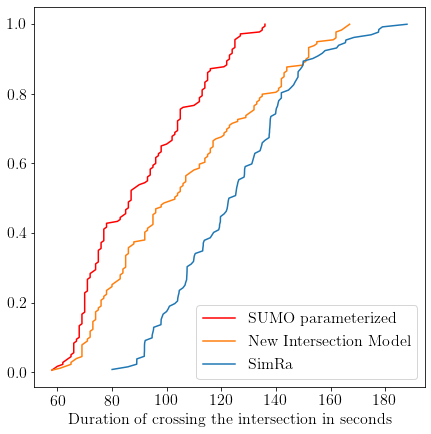

In [5]:
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib import rc

colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c']

plt.figure(figsize=(7,7))
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=True)
#plt.title('Empirical Cumulative Distribution Function')
plt.xlabel('Duration of crossing the intersection in seconds')
ecdf = ECDF(durations_arr[0])
plt.plot(ecdf.x, ecdf.y, c='r', label='SUMO parameterized')
ecdf = ECDF(durations_arr[1])
plt.plot(ecdf.x, ecdf.y, c=colors[1], label='New Intersection Model')
#ecdf = ECDF(durations_arr[2])
#plt.plot(ecdf.x, ecdf.y, label='New Intersection Model lane only')
ecdf = ECDF(simra_durations)
plt.plot(ecdf.x, ecdf.y, c=colors[0], label='SimRa')
plt.legend()
plt.savefig('images/im_mehringdamm_edcf.png', dpi=300, bbox_inches='tight')

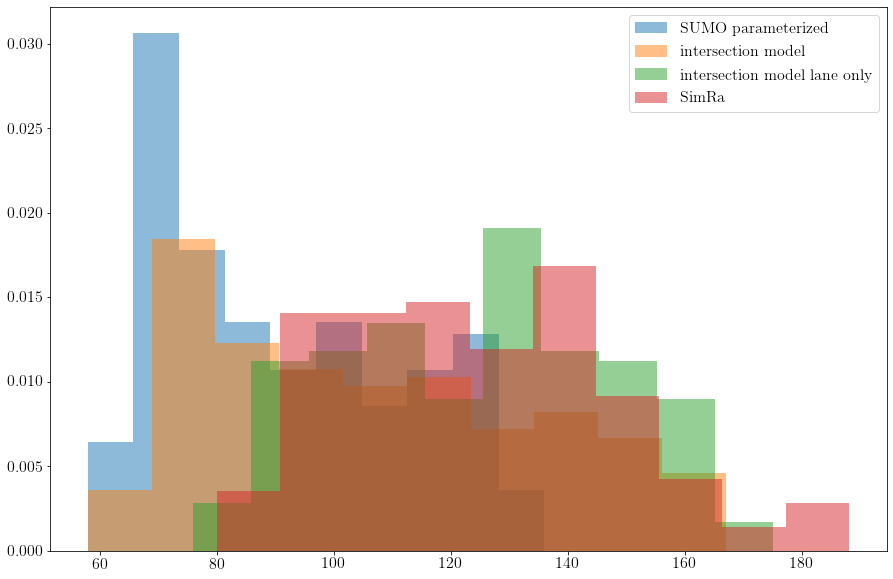

In [6]:
plt.figure(figsize=(15,10))

plt.hist(durations_arr[0],density=True, alpha=0.5, label = 'SUMO parameterized')
plt.hist(durations_arr[1],density=True, alpha=0.5, label = 'intersection model')
plt.hist(durations_arr[2],density=True, alpha=0.5, label = 'intersection model lane only')
plt.hist(simra_durations,density=True, alpha=0.5, label = 'SimRa')

plt.legend()
plt.savefig('images/im_bismarck_lane_hist.png', bbox_inches='tight')


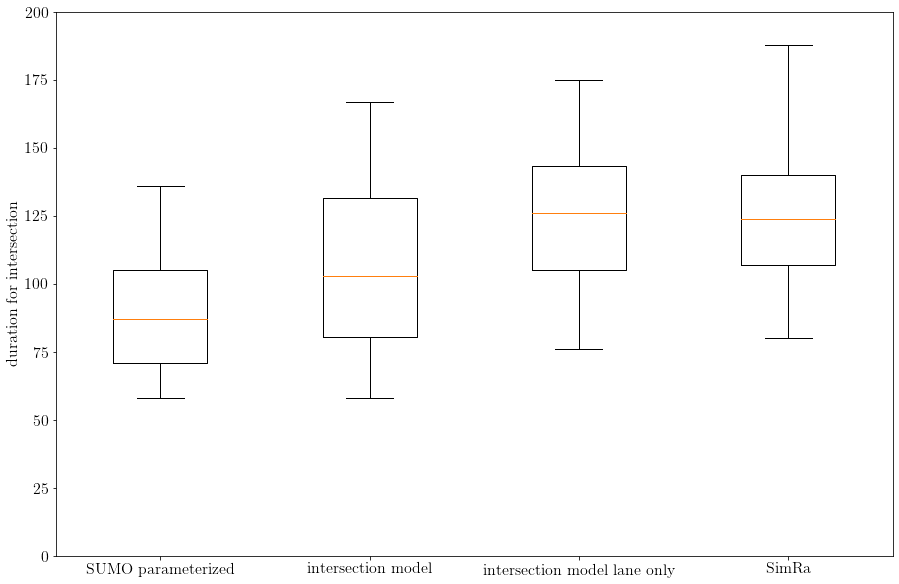

In [7]:
plt.figure(figsize=(15,10))

plt.boxplot([*durations_arr, simra_durations])
plt.xticks(np.arange(len([*durations_arr, simra_durations])) + 1, ['SUMO parameterized', 'intersection model', 'intersection model lane only', 'SimRa'])
plt.ylabel('duration for intersection')
plt.ylim(0, 200)
plt.savefig('images/im_bismarck_lane_boxplot.png', bbox_inches='tight')
